# Deteccion de enfermedades respiratorias a partir de grabaciones de ciclos respiratorios

// Add banner

## Load dataset, libraries and functions

### Google Drive

In [2]:
# Mount google drive folder and change working directory
from google.colab import drive
drive.mount('/content/drive')
%cd 'drive/MyDrive/IA-1/ai1-project'

Mounted at /content/drive
/content/drive/MyDrive/IA-1/ai1-project


### Kaggle API

In [ ]:
# Using kaggle API
! echo '{"username":"deimercastillo","key":"030249763ac6902170d2f503b807ddc2"}' > kaggle.json
! pip -q install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download vbookshelf/respiratory-sound-database
! unzip -q respiratory-sound-database.zip -d dataset

100% 3.68G/3.69G [00:36<00:00, 102MB/s]
100% 3.69G/3.69G [00:36<00:00, 108MB/s]


### Libraries

In [4]:
## Required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os
import librosa as lb
import librosa.display
import soundfile as sf

import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


### Functions

In [5]:
# functions

def filenameInfo(filename):
    return filename.split('_')

def slice_data(raw_data, start, end, sample_rate = 22050):
    max_ind = len(raw_data) 
    start_ind = min(int(start * sample_rate), max_ind)
    end_ind = min(int(end * sample_rate), max_ind)
    return raw_data[start_ind: end_ind]

def extractId(filename):
    return filename.split('_')[0]

def getFeatures(path):
    soundArr,sample_rate = lb.load(path)
    mfcc = lb.feature.mfcc(y = soundArr, sr = sample_rate)
    cstft = lb.feature.chroma_stft(y = soundArr, sr = sample_rate)
    mSpec = lb.feature.melspectrogram(y = soundArr, sr = sample_rate)
    return mfcc,cstft,mSpec


## Part 1

In [6]:
# Patient Info
patient_data = pd.read_csv('dataset/Respiratory_Sound_Database/Respiratory_Sound_Database/patient_diagnosis.csv', names = ['patientId', 'diagnosis'])
patient_data.head()
diseases = patient_data['diagnosis'].unique()
diseases.shape

(8,)

In [7]:
# Audio file info
audio_info = pd.read_csv('dataset/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/107_2b3_Lr_mc_AKGC417L.txt', sep = '\t')
audio_info.head()

,0.887,2.601,0,0.1
0,2.601,5.327,1,0
1,5.327,7.923,1,0
2,7.923,10.530,1,0
3,10.530,13.196,1,0
4,13.196,15.565,1,0


In [8]:
# Getting file list
audio_text_path = 'dataset/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/'
files = [s.split('.')[0] for s in os.listdir(path = audio_text_path) if '.txt' in s]
files[:5]

['160_1b3_Ar_mc_AKGC417L',
 '160_1b3_Al_mc_AKGC417L',
 '160_1b4_Pl_mc_AKGC417L',
 '160_1b4_Al_mc_AKGC417L',
 '160_1b4_Tc_mc_AKGC417L']

In [9]:
filenameInfo(files[12])

['160', '2b4', 'Pr', 'mc', 'AKGC417L']

In [10]:
# file name info dataframe

files_data = []
for file in files:
    data = pd.read_csv(audio_text_path + '/' + file + '.txt', sep='\t', names=['start', 'end', 'crackles', 'wheezes'])

    name_data = filenameInfo(file)
    data['patientId'] = name_data[0]
    data['mode'] = name_data[-2]
    data['filename'] = file
    files_data.append(data)
files_df = pd.concat(files_data)
files_df.reset_index()
files_df.head()


,start,end,crackles,wheezes,patientId,mode,filename
0,1.862,5.718,0,1,160,mc,160_1b3_Ar_mc_AKGC417L
1,5.718,9.725,0,1,160,mc,160_1b3_Ar_mc_AKGC417L
2,9.725,13.614,0,1,160,mc,160_1b3_Ar_mc_AKGC417L
3,13.614,17.671,0,1,160,mc,160_1b3_Ar_mc_AKGC417L
4,17.671,19.541,0,0,160,mc,160_1b3_Ar_mc_AKGC417L


In [11]:
patient_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126 entries, 0 to 125
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   patientId  126 non-null    int64 
 1   diagnosis  126 non-null    object
dtypes: int64(1), object(1)
memory usage: 2.1+ KB


In [12]:
files_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6898 entries, 0 to 1
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   start      6898 non-null   float64
 1   end        6898 non-null   float64
 2   crackles   6898 non-null   int64  
 3   wheezes    6898 non-null   int64  
 4   patientId  6898 non-null   object 
 5   mode       6898 non-null   object 
 6   filename   6898 non-null   object 
dtypes: float64(2), int64(2), object(3)
memory usage: 431.1+ KB


In [ ]:
# Change column datatype
patient_data['patientId'] = patient_data['patientId'].astype('int32')
files_df['patientId'] = files_df['patientId'].astype('int32')

In [ ]:
# Merge dataframes
data = pd.merge(files_df, patient_data, on = 'patientId')
data.head()

,start,end,crackles,wheezes,patientId,mode,filename,diagnosis
0,0.036,0.579,0,0,101,sc,101_1b1_Al_sc_Meditron,URTI
1,0.579,2.450,0,0,101,sc,101_1b1_Al_sc_Meditron,URTI
2,2.450,3.893,0,0,101,sc,101_1b1_Al_sc_Meditron,URTI
3,3.893,5.793,0,0,101,sc,101_1b1_Al_sc_Meditron,URTI
4,5.793,7.521,0,0,101,sc,101_1b1_Al_sc_Meditron,URTI


## Part 2

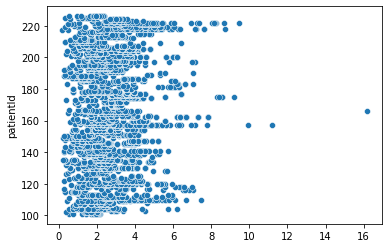

In [ ]:
sns.scatterplot(x=(data.end-data.start), y=data.patientId)

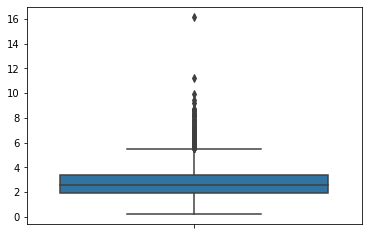

In [ ]:
sns.boxplot(y=(data.end-data.start))

In [ ]:
# Output folder
os.makedirs('processed_audio_files')

In [ ]:
# Slicing audio files
i = 0
c = 0

for index,row in data.iterrows():
    maxLen = 6
    start = row['start']
    end = row['end']
    filename = row['filename']
    
    #If len > maxLen , change it to maxLen
    if end-start>maxLen:
        end=start+maxLen
    
    audio_file_loc = audio_text_path + filename + '.wav'
    
    if index > 0:
        #check if more cycles exits for same patient if so then add i to change filename
        if data.iloc[index-1]['filename']==filename:
            i+=1
        else:
            i=0
    filename= filename + '_' + str(i) + '.wav'
    
    save_path = 'processed_audio_files/' + filename
    c += 1
    
    audioArr, sampleRate = lb.load(audio_file_loc)
    pureSample = slice_data(audioArr,start,end,sampleRate)
    
    #pad audio if pureSample len < max_len
    reqLen = 6 * sampleRate
    padded_data = lb.util.pad_center(pureSample, reqLen)
    
    sf.write(file = save_path, data = padded_data, samplerate = sampleRate)

print('Total Files Processed: ',c)

Total Files Processed:  6898


## Part X

In [13]:
path='processed_audio_files/'

length=len(os.listdir(path))
index=range(length)
i = 0

files_df=pd.DataFrame(index = index, columns=['patientId','filename'])

for f in os.listdir(path):
    files_df.iloc[i]['patientId']=extractId(f)
    files_df.iloc[i]['filename']=f
    i+=1

files_df.head()

,patientId,filename
0,204,204_7p5_Pr_mc_AKGC417L_3.wav
1,204,204_7p5_Pr_mc_AKGC417L_4.wav
2,204,204_7p5_Pr_mc_AKGC417L_5.wav
3,204,204_7p5_Pr_mc_AKGC417L_6.wav
4,204,204_7p5_Tc_mc_AKGC417L_0.wav


In [14]:
files_df['patientId'] = files_df['patientId'].astype('int64')

In [15]:
data = pd.merge(files_df, patient_data, on = 'patientId')
data.head()

,patientId,filename,diagnosis
0,204,204_7p5_Pr_mc_AKGC417L_3.wav,COPD
1,204,204_7p5_Pr_mc_AKGC417L_4.wav,COPD
2,204,204_7p5_Pr_mc_AKGC417L_5.wav,COPD
3,204,204_7p5_Pr_mc_AKGC417L_6.wav,COPD
4,204,204_7p5_Tc_mc_AKGC417L_0.wav,COPD


In [16]:
data.shape

(6898, 3)

In [17]:
# Train/Set split
X_train, X_test, y_train, y_test = train_test_split(data, data['diagnosis'], stratify = data['diagnosis'], test_size=0.2)

In [18]:
X_train['diagnosis'].value_counts()/X_train.shape[0]

COPD              0.832910
Healthy           0.046756
Pneumonia         0.041319
URTI              0.035158
Bronchiolitis     0.023197
Bronchiectasis    0.015042
LRTI              0.004712
Asthma            0.000906
Name: diagnosis, dtype: float64

In [19]:
X_test['diagnosis'].value_counts()/X_test.shape[0]

COPD              0.833333
Healthy           0.046377
Pneumonia         0.041304
URTI              0.035507
Bronchiolitis     0.023188
Bronchiectasis    0.015217
LRTI              0.004348
Asthma            0.000725
Name: diagnosis, dtype: float64

[Text(0.5, 1.0, 'MFCC')]

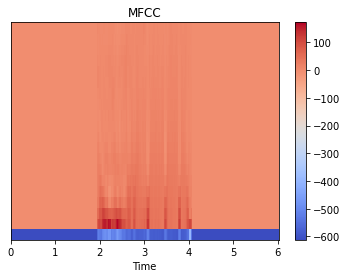

In [20]:
# MFCC Example

file = path + X_train.iloc[420].filename
sound,sample_rate = lb.load(file)
mfccs = lb.feature.mfcc(y=sound, sr=sample_rate, n_mfcc=20)
fig, ax = plt.subplots()
img = librosa.display.specshow(mfccs, x_axis='time', ax=ax)
fig.colorbar(img, ax=ax)
ax.set(title='MFCC')


In [21]:
X_train.head()

,patientId,filename,diagnosis
5037,122,122_2b3_Tc_mc_LittC2SE_0.wav,Pneumonia
4369,146,146_2b4_Al_mc_AKGC417L_0.wav,COPD
1767,200,200_2p4_Pr_mc_AKGC417L_2.wav,COPD
5963,135,135_2b3_Al_mc_LittC2SE_0.wav,Pneumonia
6582,112,112_1p1_Pr_sc_Litt3200_8.wav,COPD


In [22]:
y_test.head()

2511         COPD
3262         COPD
5996    Pneumonia
3253         COPD
2238         COPD
Name: diagnosis, dtype: object

In [23]:
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

In [24]:
# OHE
y_train_ohe = tf.keras.utils.to_categorical(y_train, num_classes = 8)
y_test_ohe = tf.keras.utils.to_categorical(y_test, num_classes = 8)

print(y_train_ohe.shape, y_test_ohe.shape)

(5518, 8) (1380, 8)


## Feature Extraction

- MFCC
- Chroma
- MSPEC



In [25]:
# Train set features

mfcc,cstft,mSpec=[],[],[]

for idx,row in X_train.iterrows():
    p = path + row['filename']
    m, c, ms = getFeatures(p)
    mfcc.append(m)
    cstft.append(c)
    mSpec.append(ms)
    
mfcc_train=np.array(mfcc)
cstft_train=np.array(cstft)
mspec_train=np.array(mSpec)

/usr/local/lib/python3.7/dist-packages/librosa/core/pitch.py:153: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn("Trying to estimate tuning from empty frequency set.")


In [26]:
# Test set features

mfcc,cstft,mSpec=[],[],[]

for idx,row in X_test.iterrows():
    p = path + row['filename']
    m, c, ms = getFeatures(p)
    mfcc.append(m)
    cstft.append(c)
    mSpec.append(ms)
    
mfcc_test=np.array(mfcc)
cstft_test=np.array(cstft)
mspec_test=np.array(mSpec)

In [34]:
# Normalize train/test
mfcc_train = mfcc_train.astype('float32')/255
cstft_train = cstft_train.astype('float32')/255
mspec_train = mspec_train.astype('float32')/255

mfcc_test = mfcc_test.astype('float32')/255
cstft_test = cstft_test.astype('float32')/255
mspec_test = mspec_test.astype('float32')/255

In [35]:
mfcc_test.shape

(1380, 20, 259)

In [36]:
cstft_test.shape

(1380, 12, 259)

In [37]:
mspec_test.shape

(1380, 128, 259)

## CNN models


## MFCC

In [46]:
# mfcc model

mfcc_model = tf.keras.models.Sequential()
mfcc_model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(20,259,1)))
mfcc_model.add(tf.keras.layers.Dropout(0.2))
mfcc_model.add(tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='valid'))
mfcc_model.add(tf.keras.layers.MaxPooling2D((2, 2)))
mfcc_model.add(tf.keras.layers.Flatten())
mfcc_model.add(tf.keras.layers.Dense(64, activation='relu'))
mfcc_model.add(tf.keras.layers.Dropout(0.3))
mfcc_model.add(tf.keras.layers.Dense(8, activation='softmax'))
mfcc_model.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 20, 259, 32)       320       
                                                                 
 dropout_4 (Dropout)         (None, 20, 259, 32)       0         
                                                                 
 conv2d_5 (Conv2D)           (None, 18, 257, 16)       4624      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 9, 128, 16)       0         
 2D)                                                             
                                                                 
 flatten_3 (Flatten)         (None, 18432)             0         
                                                                 
 dense_6 (Dense)             (None, 64)                1179712   
                                                      

In [ ]:
# Training
mfcc_model.compile(optimizer=tf.keras.optimizers.SGD(), 
              loss='categorical_crossentropy',
              metrics=['accuracy'])

mfcc_history = mfcc_model.fit(mfcc_train, y_train_ohe, epochs=10, validation_data=(mfcc_test, y_test_ohe))

Epoch 1/10
173/173 [==============================] - 64s 366ms/step - loss: 0.8224 - accuracy: 0.8307 - val_loss: 0.8406 - val_accuracy: 0.8333
Epoch 2/10
173/173 [==============================] - 64s 368ms/step - loss: 0.6986 - accuracy: 0.8325 - val_loss: 0.6250 - val_accuracy: 0.8333
Epoch 3/10
173/173 [==============================] - 64s 369ms/step - loss: 0.6347 - accuracy: 0.8304 - val_loss: 0.6518 - val_accuracy: 0.8333
Epoch 4/10
112/173 [==================>...........] - ETA: 21s - loss: 0.6065 - accuracy: 0.8331

44/44 [==============================] - 4s 89ms/step - loss: 0.5125 - accuracy: 0.8333
Test accuracy: 0.8333333134651184


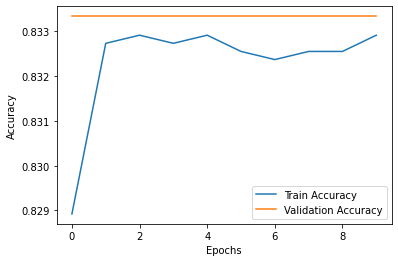

In [45]:
# Evaluating

plt.plot(mfcc_history.history['accuracy'], label='Train Accuracy')
plt.plot(mfcc_history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()


test_loss, test_acc = model.evaluate(mfcc_test, y_test_ohe)
print('Test accuracy:', test_acc)

## Chroma

In [ ]:
# chroma_model

cstft_model =  tf.keras.models.Sequential()
cstft_model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(12,259,1)))
cstft_model.add(tf.keras.layers.MaxPooling2D((2, 2)))
cstft_model.add(tf.keras.layers.Flatten())
cstft_model.add(tf.keras.layers.Dense(64, activation='relu'))
cstft_model.add(tf.keras.layers.Dense(8, activation='softmax'))
cstft_model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 12, 259, 32)       320       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 129, 32)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 24768)             0         
                                                                 
 dense_2 (Dense)             (None, 64)                1585216   
                                                                 
 dense_3 (Dense)             (None, 8)                 520       
                                                                 
Total params: 1,586,056
Trainable params: 1,586,056
Non-trainable params: 0
____________________________________________

In [ ]:
# Training
cstft_model.compile(optimizer=tf.keras.optimizers.SGD(), 
              loss='categorical_crossentropy',
              metrics=['accuracy'])

cstft_history = cstft_model.fit(cstft_train, y_train_ohe, epochs=10, validation_data=(cstft_test, y_test_ohe))

Epoch 1/10
173/173 [==============================] - 13s 65ms/step - loss: 0.7298 - accuracy: 0.8329 - val_loss: 0.7417 - val_accuracy: 0.8333
Epoch 2/10
173/173 [==============================] - 11s 64ms/step - loss: 0.7291 - accuracy: 0.8329 - val_loss: 0.7425 - val_accuracy: 0.8333
Epoch 3/10
173/173 [==============================] - 11s 64ms/step - loss: 0.7311 - accuracy: 0.8329 - val_loss: 0.7356 - val_accuracy: 0.8333
Epoch 4/10
173/173 [==============================] - 11s 64ms/step - loss: 0.7307 - accuracy: 0.8329 - val_loss: 0.7433 - val_accuracy: 0.8333
Epoch 5/10
173/173 [==============================] - 11s 65ms/step - loss: 0.7310 - accuracy: 0.8329 - val_loss: 0.7247 - val_accuracy: 0.8333
Epoch 6/10
173/173 [==============================] - 11s 64ms/step - loss: 0.7301 - accuracy: 0.8329 - val_loss: 0.7296 - val_accuracy: 0.8333
Epoch 7/10
173/173 [==============================] - 11s 64ms/step - loss: 0.7300 - accuracy: 0.8329 - val_loss: 0.7282 - val_accuracy:

44/44 [==============================] - 1s 19ms/step - loss: 0.7310 - accuracy: 0.8333
Test accuracy: 0.8333333134651184


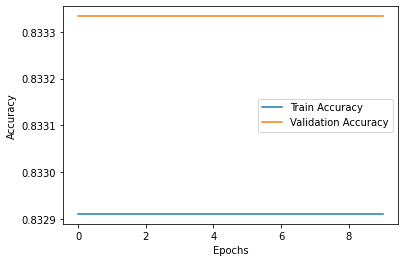

In [ ]:
# Evaluating

plt.plot(cstft_history.history['accuracy'], label='Train Accuracy')
plt.plot(cstft_history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()


test_loss, test_acc = cstft_model.evaluate(cstft_test, y_test_ohe)
print('Test accuracy:', test_acc)

## MSPEC

In [ ]:
# mspec_model

mspec_model =  tf.keras.models.Sequential()
mspec_model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(128,259,1)))
mspec_model.add(tf.keras.layers.MaxPooling2D((2, 2)))
mspec_model.add(tf.keras.layers.Flatten())
mspec_model.add(tf.keras.layers.Dense(64, activation='relu'))
mspec_model.add(tf.keras.layers.Dense(8, activation='softmax'))
mspec_model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 128, 259, 32)      320       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 64, 129, 32)      0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 264192)            0         
                                                                 
 dense_4 (Dense)             (None, 64)                16908352  
                                                                 
 dense_5 (Dense)             (None, 8)                 520       
                                                                 
Total params: 16,909,192
Trainable params: 16,909,192
Non-trainable params: 0
__________________________________________

In [ ]:
# Training
mspec_model.compile(optimizer=tf.keras.optimizers.SGD(), 
              loss='categorical_crossentropy',
              metrics=['accuracy'])

mspec_history = mspec_model.fit(mspec_train, y_train_ohe, epochs=10, validation_data=(mspec_test, y_test_ohe))

Epoch 1/10
173/173 [==============================] - 106s 609ms/step - loss: 0.6761 - accuracy: 0.8293 - val_loss: 0.6131 - val_accuracy: 0.8333
Epoch 2/10
173/173 [==============================] - 108s 624ms/step - loss: 0.6151 - accuracy: 0.8329 - val_loss: 0.5982 - val_accuracy: 0.8333
Epoch 3/10
173/173 [==============================] - 105s 609ms/step - loss: 0.5994 - accuracy: 0.8327 - val_loss: 0.5880 - val_accuracy: 0.8333
Epoch 4/10
173/173 [==============================] - 107s 619ms/step - loss: 0.5907 - accuracy: 0.8329 - val_loss: 0.5889 - val_accuracy: 0.8333
Epoch 5/10
173/173 [==============================] - 106s 610ms/step - loss: 0.5815 - accuracy: 0.8329 - val_loss: 0.5721 - val_accuracy: 0.8333
Epoch 6/10
173/173 [==============================] - 105s 609ms/step - loss: 0.5728 - accuracy: 0.8329 - val_loss: 0.5741 - val_accuracy: 0.8326
Epoch 7/10
173/173 [==============================] - 106s 610ms/step - loss: 0.5648 - accuracy: 0.8331 - val_loss: 0.5682 -

44/44 [==============================] - 7s 165ms/step - loss: 0.5535 - accuracy: 0.8333
Test accuracy: 0.8333333134651184


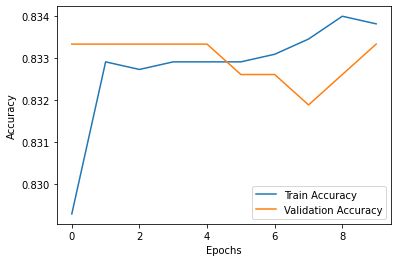

In [ ]:
# Evaluating

plt.plot(mspec_history.history['accuracy'], label='Train Accuracy')
plt.plot(mspec_history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()


test_loss, test_acc = mspec_model.evaluate(mspec_test.astype('float32')/255, y_test_ohe)
print('Test accuracy:', test_acc)